In [ ]:
# Install missing libraries (if needed)
!pip install nltk
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install tensorflow


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Downloading nltk data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:

# Load dataset
df = pd.read_csv('news.csv') 
df.head()


,date,news,neg,neu,pos,compound,sentiment
0,2007-07-07,It was a long antipodean night. While there’s ...,0.059000,0.87800,0.064000,0.051600,POSITIVE
1,2007-07-07,In Mexico there are no licensing or registrati...,0.044000,0.95600,0.000000,-0.296000,NEGATIVE
2,2007-07-07,The government has until Monday to protect the...,0.000000,0.89400,0.106000,0.381800,POSITIVE
3,2007-07-07,A record-breaking heat wave in the Southwest i...,0.197505,0.66149,0.141005,0.997491,POSITIVE
4,2007-07-07,England started its Live Earth concert at Wemb...,0.033000,0.94500,0.022000,-0.177900,NEGATIVE


In [ ]:
 print(df.columns)


Index(['date', 'news', 'neg', 'neu', 'pos', 'compound', 'sentiment'], dtype='object')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427482 entries, 0 to 427481
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       427482 non-null  object 
 1   news       427482 non-null  object 
 2   neg        427482 non-null  float64
 3   neu        427482 non-null  float64
 4   pos        427482 non-null  float64
 5   compound   427482 non-null  float64
 6   sentiment  427482 non-null  object 
dtypes: float64(4), object(3)
memory usage: 22.8+ MB


In [ ]:
# Step 1: Checking for missing values
print(df.isnull().sum())


date         0
news         0
neg          0
neu          0
pos          0
compound     0
sentiment    0
dtype: int64


In [ ]:
# Step 2: Keeping only 'news' and 'sentiment' columns
df = df[['news', 'sentiment']]

# Verifying the change
df.head()


,news,sentiment
0,It was a long antipodean night. While there’s ...,POSITIVE
1,In Mexico there are no licensing or registrati...,NEGATIVE
2,The government has until Monday to protect the...,POSITIVE
3,A record-breaking heat wave in the Southwest i...,POSITIVE
4,England started its Live Earth concert at Wemb...,NEGATIVE


In [ ]:
# Step 3: Cleaning the text data
import re

def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Removing special characters, numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Removing extra spaces
    return text

# Apply cleaning function
df['clean_news'] = df['news'].apply(clean_text)

# Let's check the cleaned data
df[['news', 'clean_news']].head()


,news,clean_news
0,It was a long antipodean night. While there’s ...,it was a long antipodean night while theres no...
1,In Mexico there are no licensing or registrati...,in mexico there are no licensing or registrati...
2,The government has until Monday to protect the...,the government has until monday to protect the...
3,A record-breaking heat wave in the Southwest i...,a recordbreaking heat wave in the southwest is...
4,England started its Live Earth concert at Wemb...,england started its live earth concert at wemb...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427482 entries, 0 to 427481
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   news        427482 non-null  object
 1   sentiment   427482 non-null  object
 2   clean_news  427482 non-null  object
dtypes: object(3)
memory usage: 9.8+ MB


In [ ]:
# Step 4: Encode the labels
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()

# Fit and transform the sentiment column
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])

# Let's check
df[['sentiment', 'sentiment_encoded']].head()


,sentiment,sentiment_encoded
0,POSITIVE,1
1,NEGATIVE,0
2,POSITIVE,1
3,POSITIVE,1
4,NEGATIVE,0


In [ ]:
# Step 5: Train-test split
from sklearn.model_selection import train_test_split

# Features (X) and Labels (y)
X = df['clean_news']           # Text data
y = df['sentiment_encoded']    # Encoded labels

# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")


Training samples: 341985
Testing samples: 85497


In [ ]:
# Step 6: Vectorize text data using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Limit features to 5000

# Fit and transform on training data, transform on test data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF vectorization complete!")
print(f"Training data shape: {X_train_tfidf.shape}")
print(f"Testing data shape: {X_test_tfidf.shape}")  # Fixed line


TF-IDF vectorization complete!
Training data shape: (341985, 5000)
Testing data shape: (85497, 5000)


In [ ]:
# Step 7: Build and train a Logistic Regression model
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression
model = LogisticRegression(max_iter=341985)  # Increased iterations for better convergence

# Train the model
model.fit(X_train_tfidf, y_train)

print("Model training complete!")


Model training complete!


Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     43489
           1       0.84      0.85      0.85     42008

    accuracy                           0.85     85497
   macro avg       0.85      0.85      0.85     85497
weighted avg       0.85      0.85      0.85     85497



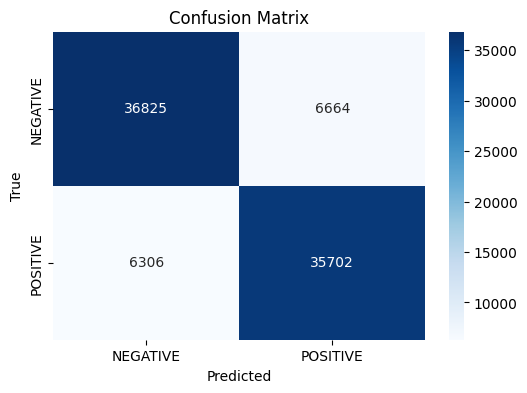

In [ ]:
# Step 8: Model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_pred = model.predict(X_test_tfidf)

# Evaluation metrics
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


<ipython-input-25-9598b5923854>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=scores, palette="viridis")


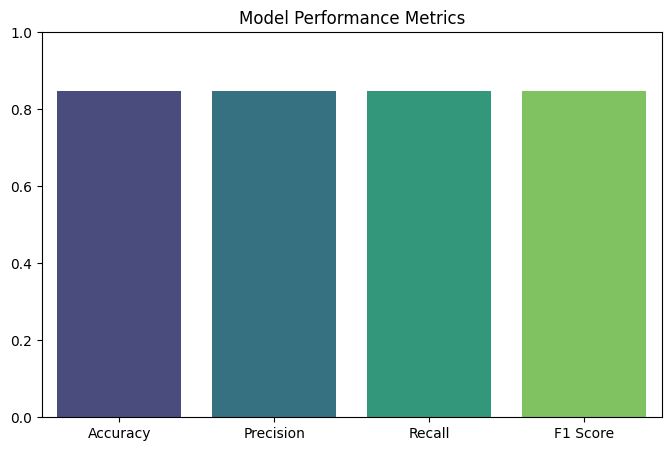

In [ ]:
# Step 9: Visualize Metrics

# Calculate individual scores
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # weighted because multiclass
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Bar graph
scores = [accuracy, precision, recall, f1]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(8,5))
sns.barplot(x=metrics, y=scores, palette="viridis")
plt.ylim(0, 1)
plt.title("Model Performance Metrics")
plt.show()
